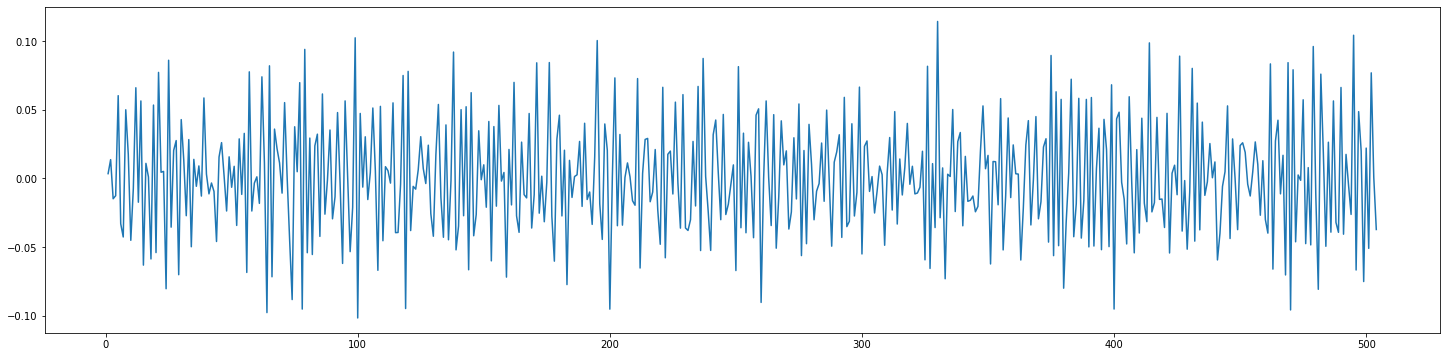

In [19]:
import torch
import torch.nn as nn 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
import statistics

#Reading data from csv file and calculating return price
df = pd.read_csv('Stock_Review.csv')
price = df['CLA'].shift(1)
return_price = (df['CLA'] - price) / price
plt.plot(return_price)


In [20]:
#Normalizing training data (we start from one, because we shift data by 1)
return_ = return_price.values[1:].reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(return_[: (2 * len(return_)) // 3])
return_ = scaler.transform(return_).flatten()


In [21]:
#We use T past values to predict next value
#Our data has D dimention
#Now we start to build data set
T = 7
D = 1
X = []
Y = []
for t in range(len(return_) - T):
    x = return_[t:t+T]
    X.append(x)
    y = return_[t+T]
    Y.append(y)
X = np.array(X).reshape(-1,T,1) #Data should be N * T * D
Y = np.array(Y).reshape(-1,1)
N = len(X)
print('X.shape', X.shape, 'Y.shape', Y.shape)

X.shape (497, 7, 1) Y.shape (497, 1)


In [22]:
#Thsi is our model. LSTM model with M hidden cells and L layers
class RNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(RNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers

        self.rnn = nn.LSTM(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            batch_first=True,
            dropout=0.7)
        self.fc = nn.Linear(self.M, self.K)
    
    def forward(self, X):
        h0 = torch.zeros(self.L, X.size(0), self.M)
        c0 = torch.zeros(self.L, X.size(0), self.M)
        out, _ = self.rnn(X, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


In [23]:
#Now we call our model with arbitary inputs
#We define our loss function and optimizer
model = RNN(1, 15, 1, 1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.3)
#We preare train and target data sets
X_train = torch.from_numpy(X[ :(-1 * N)//3].astype(np.float32))
y_train = torch.from_numpy(Y[:(-1 * N)//3].astype(np.float32))
X_test = torch.from_numpy(X[(-1 * N)//3:].astype(np.float32))
y_test = torch.from_numpy(Y[(-1 * N)//3:].astype(np.float32))

c:\Users\mostafa.shiri\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [24]:
#The trainig function (gradient descent)
def full_gd(model,
            criterion,
            optimizer, 
            X_train,
            y_train,
            X_test,
            y_test,
            epochs=500):

    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses [it] = loss.item()
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()


        if (it + 1) % 5 == 0:
            print(f'Epoch {it + 1} / {epochs}, Train Loss: {loss.item(): .4f}, Test Loss : {test_loss.item(): .4f}')
    print(statistics.mean(test_losses))
    print(statistics.mean(train_losses))

    return train_losses, test_losses

In [25]:
#We call trainig function with defined inputs
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5 / 500, Train Loss:  0.9934, Test Loss :  1.2718
Epoch 10 / 500, Train Loss:  1.1580, Test Loss :  1.1233
Epoch 15 / 500, Train Loss:  0.7931, Test Loss :  0.8206
Epoch 20 / 500, Train Loss:  0.6707, Test Loss :  0.6906
Epoch 25 / 500, Train Loss:  0.6249, Test Loss :  0.7053
Epoch 30 / 500, Train Loss:  0.5812, Test Loss :  0.6919
Epoch 35 / 500, Train Loss:  0.5448, Test Loss :  0.7472
Epoch 40 / 500, Train Loss:  0.5526, Test Loss :  0.7151
Epoch 45 / 500, Train Loss:  0.5338, Test Loss :  0.7113
Epoch 50 / 500, Train Loss:  0.5214, Test Loss :  0.7435
Epoch 55 / 500, Train Loss:  0.5196, Test Loss :  0.7228
Epoch 60 / 500, Train Loss:  0.5105, Test Loss :  0.7674
Epoch 65 / 500, Train Loss:  0.4968, Test Loss :  0.7818
Epoch 70 / 500, Train Loss:  0.4886, Test Loss :  0.7603
Epoch 75 / 500, Train Loss:  0.4803, Test Loss :  0.7907
Epoch 80 / 500, Train Loss:  0.4848, Test Loss :  0.7724
Epoch 85 / 500, Train Loss:  0.4813, Test Loss :  0.8417
Epoch 90 / 500, Train Loss:  0.4

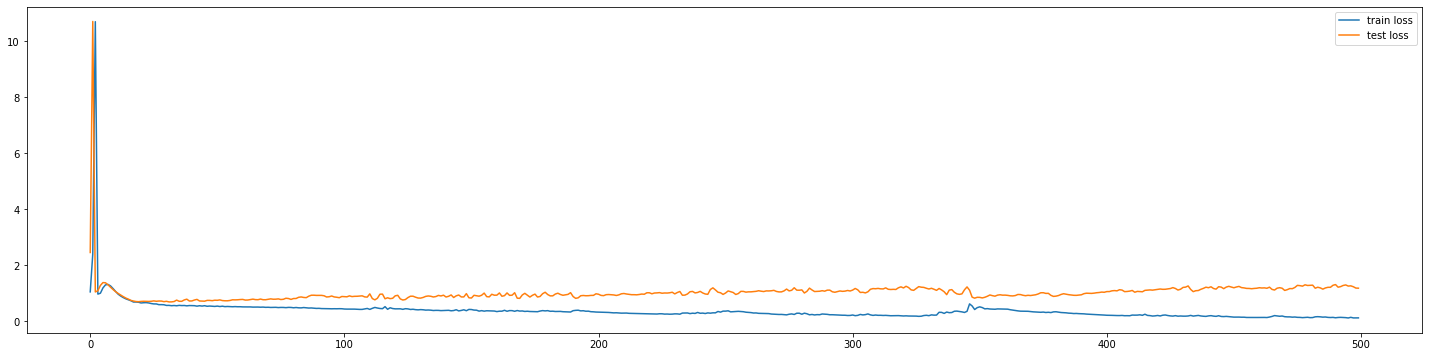

In [26]:
#Now we plot the test losses and train losses per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.rcParams['figure.figsize'] = 25, 6
plt.legend()
plt.show()

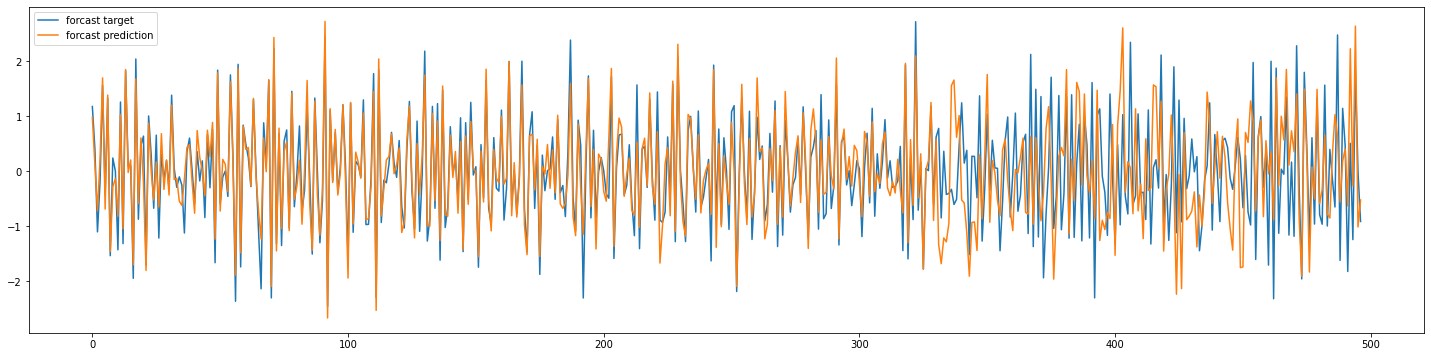

In [27]:
#Forcast with true targets
validation_target = Y
validation_prediction = []
i = 0
in_ = torch.from_numpy(X.astype(np.float32))
while len(validation_prediction) < len(validation_target):
    input_ = in_[i].reshape(1,T, 1)
    p = model(input_)[0,0].item()
    i += 1
    validation_prediction.append(p)
#Ploting forcast targets and forcast predictions
plt.plot(validation_target, label='forcast target')
plt.plot(validation_prediction, label='forcast prediction')
plt.legend()
plt.show()